In [20]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
All required packages have been successfully installed!


In [21]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from typing import Dict, List, Tuple
from torchprofile import profile_macs

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [22]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)


In [23]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

In [24]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements




def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [25]:
import torchvision.transforms as transforms # Import transforms from torchvision
import torchvision.datasets as datasets  # Import datasets from torchvision

image_size = 32

# Define transformations for train and test separately
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))  # CIFAR-100 normalization
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))  # CIFAR-100 normalization
    ]),
}


# Create datasets and dataloaders
dataset = {}
for split in ["train", "test"]:
    dataset[split] = datasets.CIFAR100( # Use datasets.CIFAR100 to access the dataset
        root="data/cifar100",
        train=(split == "train"),
        download=True,
        transform=data_transforms[split], # Use the dictionary to access the correct transforms
    )

dataloader = {}
for split in ["train", "test"]:
    dataloader[split] = DataLoader(dataset[split], batch_size=512, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


# Task 1.1: Unstructured Pruning

In [26]:
def unstructured_prune(tensor: torch.Tensor, target_sparsity: float) -> torch.Tensor:
    """
    Performs fine-grained magnitude-based pruning on the tensor.

    Args:
        tensor: Input tensor to be pruned
        target_sparsity: Desired sparsity ratio (between 0 and 1)

    Returns:
        mask: Binary mask of the same shape as tensor (1s indicate kept weights)
    """
     # Ensure sparsity is within the valid range
    sparsity = min(max(0.0, target_sparsity), 1.0)

    # Handle edge cases for full pruning or no pruning
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    # Step 1: Calculate the number of elements to zero out
    num_elements = tensor.numel()
    num_zeros = round(num_elements * sparsity)

    # Step 2: Calculate the L2 norm-based importance of each weight
    importance = tensor.pow(2).sqrt()  # L2 norm magnitude of weights

    # Step 3: Find the pruning threshold based on importance
    threshold = torch.sort(importance.flatten())[0][num_zeros]  # Threshold to prune lowest magnitudes

    # Step 4: Create a binary mask based on the threshold
    mask = (importance >= threshold).float()

    # Step 5: Apply mask to the tensor (prune weights below threshold)
    tensor.mul_(mask)

    return mask

def prune_model(model: nn.Module, target_sparsity: float) -> nn.Module:
    """
    Applies fine-grained pruning to all weight tensors in the model

    Args:
        model: The neural network model to prune
        target_sparsity: Desired sparsity ratio (between 0 and 1)

    Returns:
        model: Pruned model
    """
    # Create a copy of the model to avoid modifying the original
    pruned_model = copy.deepcopy(model)

    # Prune each parameter tensor
    for name, module in pruned_model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            unstructured_prune(module.weight.data, target_sparsity)

    return pruned_model

def evaluate_pruning(model, target_sparsities, dataloader_test):
    """
    Evaluates model performance across different sparsity levels

    Args:
        model: The neural network model
        target_sparsities: List of sparsity ratios to test
        dataloader_test: Test data loader

    Returns:
        results: Dictionary containing evaluation metrics
    """
    results = {
        'sparsities': [],
        'accuracies': [],
        'sizes': []
    }

    # Get sample input for MACs calculation
    sample_input = next(iter(dataloader_test))[0][:1].cuda()

    for sparsity in target_sparsities:
        # Prune model
        pruned_model = prune_model(model, sparsity)

        # Evaluate
        accuracy = evaluate(pruned_model, dataloader_test, verbose=False)
        model_size = get_model_size(pruned_model, count_nonzero_only=True) / MiB  # Convert to MiB
        macs = get_model_macs(pruned_model, sample_input)

        # Store results
        results['sparsities'].append(sparsity)
        results['accuracies'].append(accuracy)
        results['sizes'].append(model_size)

        print(f"Sparsity: {sparsity:.2f}, Accuracy: {accuracy:.2f}%, "
              f"Size: {model_size:.2f} MiB")
        print(f"Weight distribution for sparsity level {sparsity}:")
        plot_weight_distribution(pruned_model)

    return results

def plot_pruning_results(results):
    """
    Plots the results of pruning evaluation
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy vs Sparsity
    ax1.plot(results['sparsities'], results['accuracies'], 'bo-')
    ax1.set_xlabel('Sparsity Ratio')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Accuracy vs Sparsity')
    ax1.grid(True)

    # Model Size vs Sparsity
    # Convert sizes to CPU before plotting to avoid TypeError
    sizes_cpu = [size.cpu().item() if isinstance(size, torch.Tensor) else size for size in results['sizes']]
    ax2.plot(results['sparsities'], sizes_cpu, 'ro-')
    ax2.set_xlabel('Sparsity Ratio')
    ax2.set_ylabel('Model Size (MiB)')
    ax2.set_title('Model Size vs Sparsity')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    # Calculate the number of plots needed
    num_plots = sum(1 for name, param in model.named_parameters() if param.dim() > 1)

    # Calculate the number of rows and columns for subplots
    num_cols = 3  # You can adjust this
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate rows based on plots and columns

    # Create subplots with the calculated dimensions
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 2 * num_rows))  # Adjust figsize as needed
    axes = axes.ravel()

    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color='blue', alpha=0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color='blue', alpha=0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1

    # Hide any unused subplots
    for i in range(plot_index, len(axes)):
        axes[i].axis('off')

    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()




In [27]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=True)
model = model.cuda()
# Test sparsity levels

target_sparsities = [0.0, 0.25, 0.5, 0.75, 0.9]


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master



Evaluating pruning at different sparsity levels:
Sparsity: 0.00, Accuracy: 70.77%, Size: 37.39 MiB
Weight distribution for sparsity level 0.0:


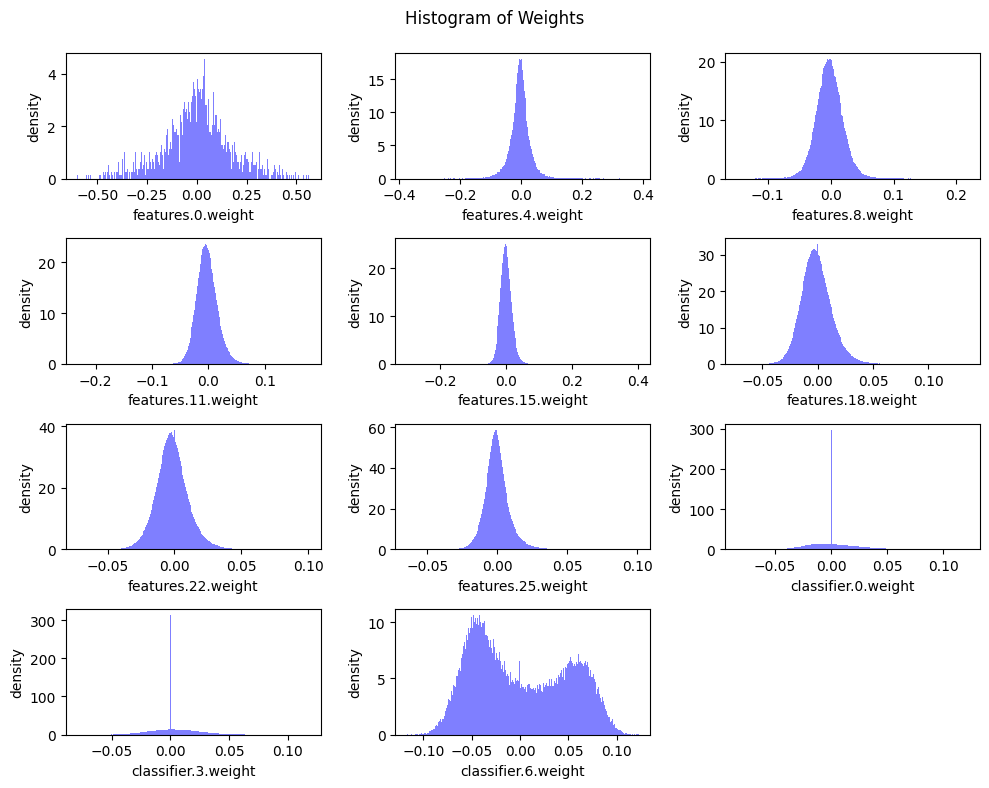

Sparsity: 0.25, Accuracy: 70.61%, Size: 28.05 MiB
Weight distribution for sparsity level 0.25:


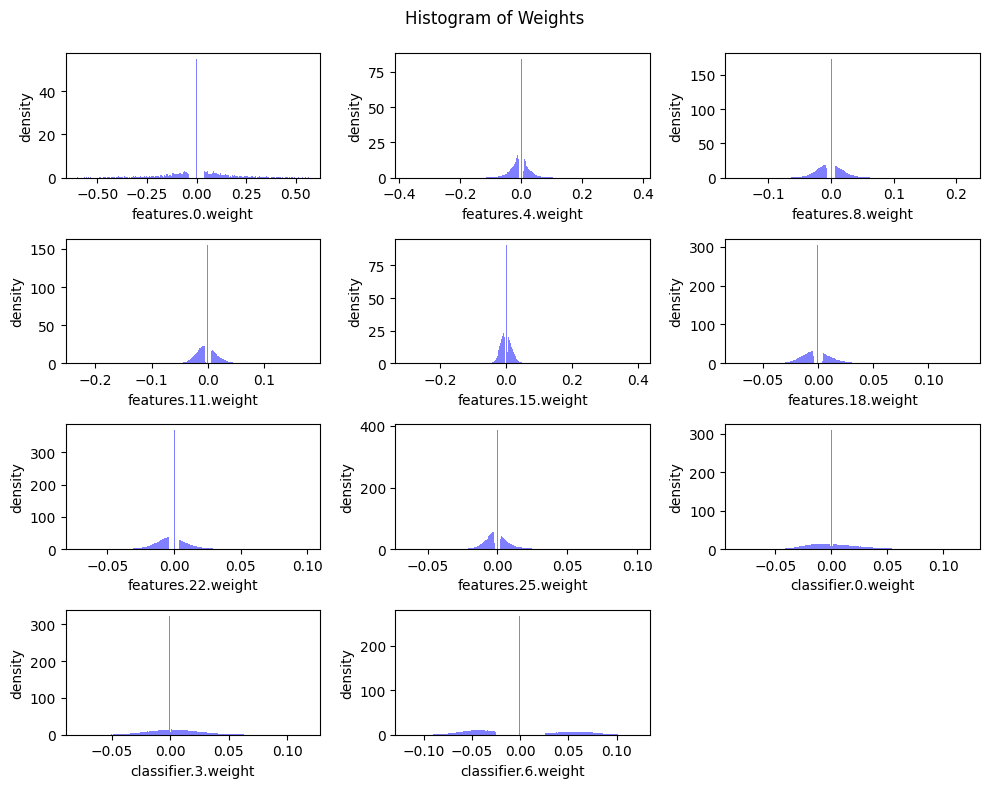

Sparsity: 0.50, Accuracy: 60.91%, Size: 18.71 MiB
Weight distribution for sparsity level 0.5:


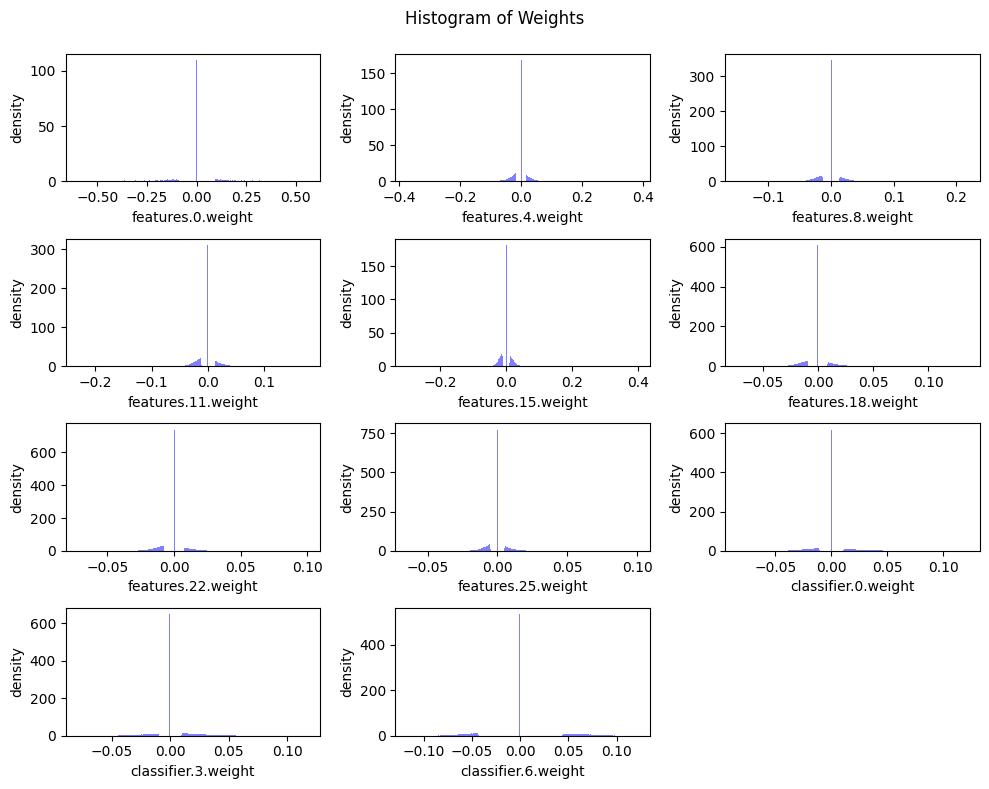

Sparsity: 0.75, Accuracy: 11.06%, Size: 9.38 MiB
Weight distribution for sparsity level 0.75:


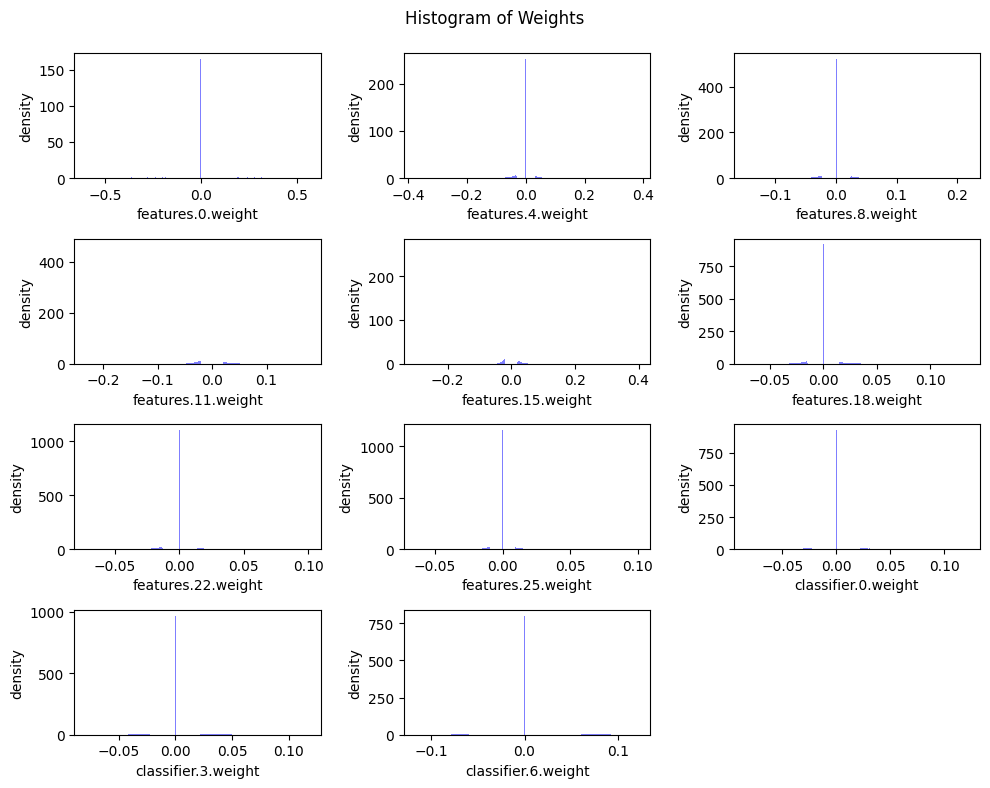

Sparsity: 0.90, Accuracy: 1.01%, Size: 3.77 MiB
Weight distribution for sparsity level 0.9:


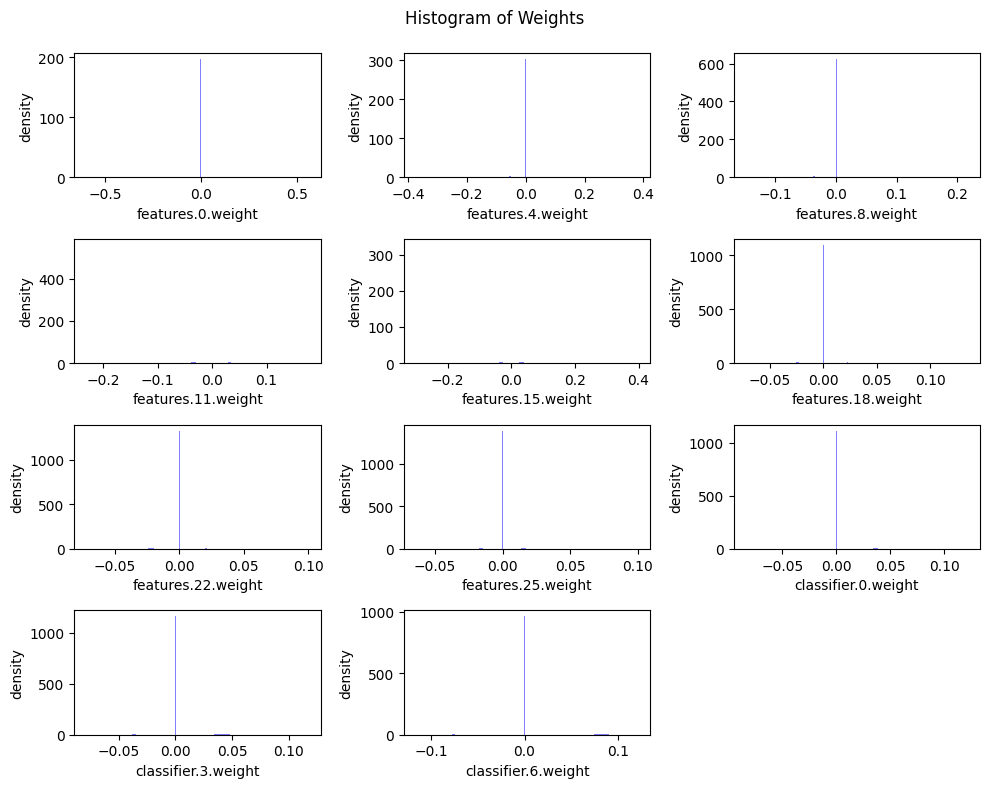

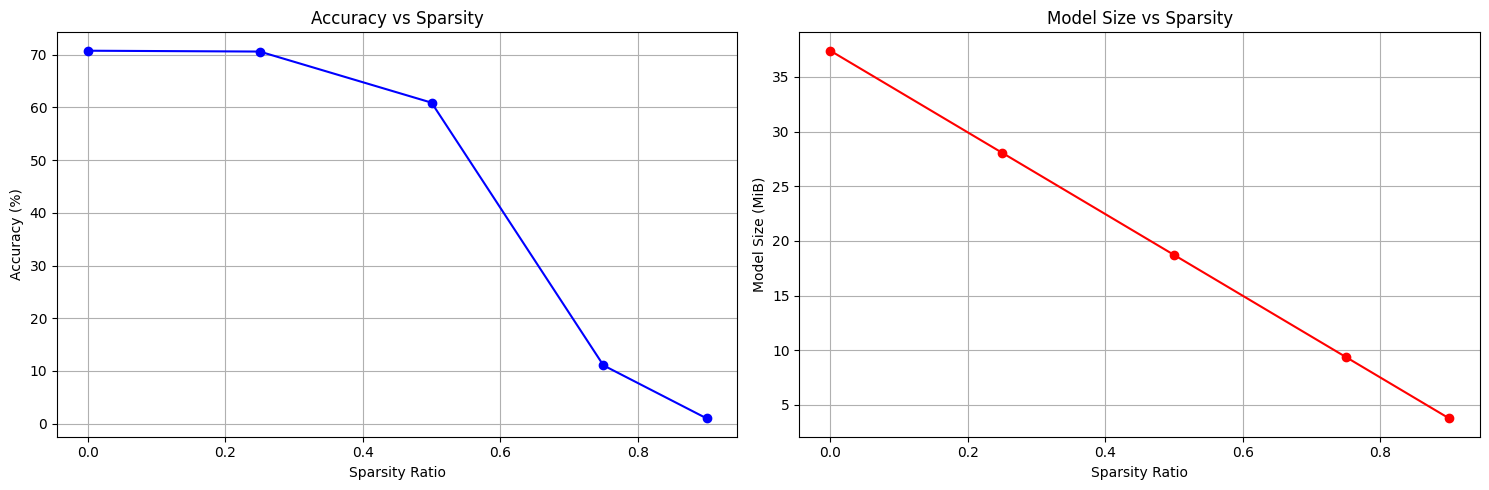

In [28]:
# Evaluate pruning
print("\nEvaluating pruning at different sparsity levels:")
results = evaluate_pruning(model, target_sparsities, dataloader['test'])

# Plot results
plot_pruning_results(results)


Analyzing sensitivity of layer: features.0
Sparsity: 0.00, Accuracy: 70.77%, Drop: 0.00%
Sparsity: 0.25, Accuracy: 70.59%, Drop: 0.18%
Sparsity: 0.50, Accuracy: 63.20%, Drop: 7.57%
Sparsity: 0.75, Accuracy: 17.88%, Drop: 52.89%
Sparsity: 0.90, Accuracy: 4.70%, Drop: 66.07%

Analyzing sensitivity of layer: features.4
Sparsity: 0.00, Accuracy: 70.77%, Drop: 0.00%
Sparsity: 0.25, Accuracy: 70.79%, Drop: -0.02%
Sparsity: 0.50, Accuracy: 70.31%, Drop: 0.46%
Sparsity: 0.75, Accuracy: 63.12%, Drop: 7.65%
Sparsity: 0.90, Accuracy: 24.94%, Drop: 45.83%

Analyzing sensitivity of layer: features.8
Sparsity: 0.00, Accuracy: 70.77%, Drop: 0.00%
Sparsity: 0.25, Accuracy: 70.72%, Drop: 0.05%
Sparsity: 0.50, Accuracy: 70.37%, Drop: 0.40%
Sparsity: 0.75, Accuracy: 64.11%, Drop: 6.66%
Sparsity: 0.90, Accuracy: 23.51%, Drop: 47.26%

Analyzing sensitivity of layer: features.11
Sparsity: 0.00, Accuracy: 70.77%, Drop: 0.00%
Sparsity: 0.25, Accuracy: 70.73%, Drop: 0.04%
Sparsity: 0.50, Accuracy: 70.12%, Dro

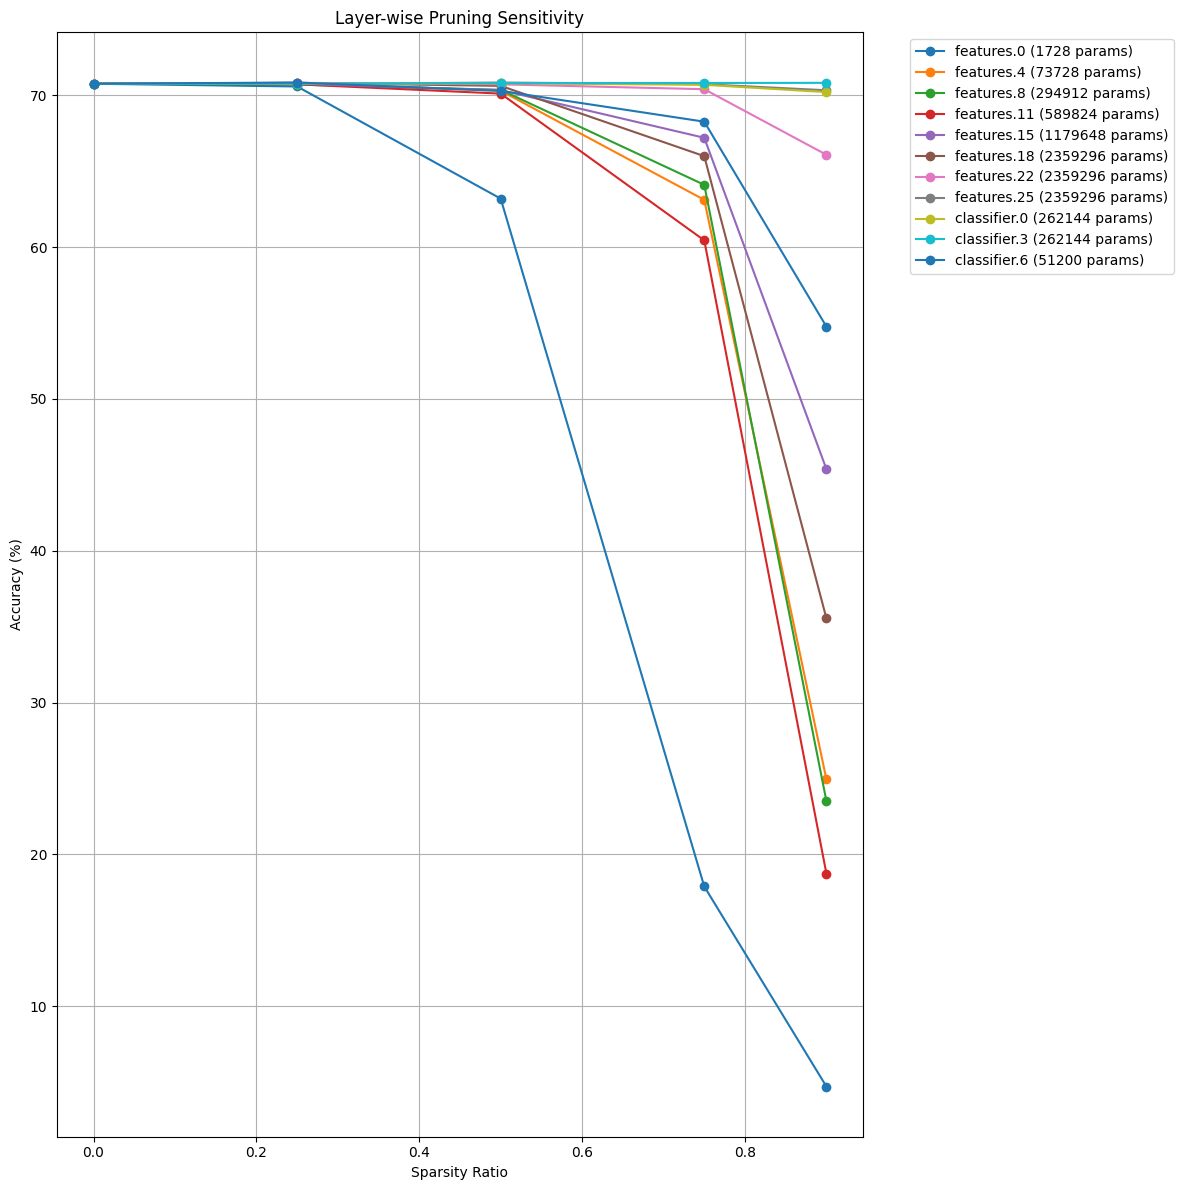

In [29]:
def analyze_layer_sensitivity(
    model: nn.Module,
    dataloader: DataLoader,
    sparsity_levels: List[float],
    verbose: bool = True
) -> Dict:
    """
    Analyze sensitivity of each layer to pruning by independently pruning layers
    and measuring accuracy impact.

    Returns:
        Dictionary containing per-layer sensitivity results
    """
    results = {}
    base_accuracy = evaluate(model, dataloader, verbose=False)

    for name, module in model.named_modules():
        if not isinstance(module, (nn.Conv2d, nn.Linear)):
            continue

        layer_results = {
            'sparsities': [],
            'accuracies': [],
            'accuracy_drops': [],
            'param_count': module.weight.numel(),
            'shape': list(module.weight.shape)
        }

        # Store original weights to reset after each sparsity test
        original_weights = module.weight.data.clone()

        print(f"\nAnalyzing sensitivity of layer: {name}")

        for sparsity in sparsity_levels:
            # Apply pruning to the layer weights
            mask = unstructured_prune(module.weight.data, sparsity)

            # Evaluate model with pruned weights
            accuracy = evaluate(model, dataloader, verbose=False)
            accuracy_drop = base_accuracy - accuracy

            # Store the results for this sparsity level
            layer_results['sparsities'].append(sparsity)
            layer_results['accuracies'].append(accuracy)
            layer_results['accuracy_drops'].append(accuracy_drop)

            if verbose:
                print(f"Sparsity: {sparsity:.2f}, Accuracy: {accuracy:.2f}%, "
                      f"Drop: {accuracy_drop:.2f}%")

            # Reset to original weights before the next sparsity level
            module.weight.data = original_weights.clone()

        results[name] = layer_results

    return results

def plot_sensitivity_analysis(results: Dict):
    """
    Visualize the sensitivity analysis results
    """
    num_layers = len(results)
    fig, ax1 = plt.subplots(1, 1, figsize=(12, 12))

    # Plot accuracy drops for each layer
    for name, layer_results in results.items():
        ax1.plot(layer_results['sparsities'],
                layer_results['accuracies'],
                'o-',
                label=f"{name} ({layer_results['param_count']} params)")

    ax1.set_xlabel('Sparsity Ratio')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Layer-wise Pruning Sensitivity')
    ax1.grid(True)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

def calculate_layerwise_sparsity_targets(
    sensitivity_results: Dict,
    target_overall_sparsity: float = 0.25
) -> Dict[str, float]:
    """
    Calculate per-layer sparsity targets based on sensitivity analysis
    to achieve desired overall sparsity while minimizing accuracy impact
    """
    total_params = sum(layer['param_count'] for layer in sensitivity_results.values())

    # Calculate sensitivity scores (average accuracy drop per sparsity unit)
    sensitivity_scores = {}
    for name, results in sensitivity_results.items():
        drops = np.array(results['accuracy_drops'])
        sparsities = np.array(results['sparsities'])
        # Calculate average slope of accuracy drop vs sparsity
        sensitivity_scores[name] = np.mean(drops / (sparsities + 1e-6))

    # Inverse sensitivity scores (less sensitive layers get higher scores)
    max_score = max(sensitivity_scores.values())
    inverse_scores = {name: max_score - score
                     for name, score in sensitivity_scores.items()}

    # Normalize scores
    total_score = sum(inverse_scores.values())
    normalized_scores = {name: score / total_score
                        for name, score in inverse_scores.items()}

    # Calculate target sparsities
    layer_sparsities = {}
    for name, score in normalized_scores.items():
        params = sensitivity_results[name]['param_count']
        # Layers with higher normalized scores get higher sparsity
        sparsity = target_overall_sparsity * (1 + score)
        # Ensure sparsity is between 0 and 1
        sparsity = min(max(sparsity, 0.0), 0.9)  # Cap at 90% sparsity
        layer_sparsities[name] = sparsity

    return layer_sparsities

# Run the analysis
sparsity_levels = [0.0, 0.25, 0.5, 0.75, 0.9]
sensitivity_results = analyze_layer_sensitivity(model, dataloader['test'], sparsity_levels)

# Visualize results
plot_sensitivity_analysis(sensitivity_results)



In [30]:
# Calculate targeted layer-wise sparsity
layer_sparsities = calculate_layerwise_sparsity_targets(sensitivity_results, 0.25)
print("\nRecommended layer-wise sparsity targets for 25% overall sparsity:")
for layer, sparsity in layer_sparsities.items():
    print(f"{layer}: {sparsity:.3f}")


Recommended layer-wise sparsity targets for 25% overall sparsity:
features.0: 0.250
features.4: 0.269
features.8: 0.269
features.11: 0.267
features.15: 0.274
features.18: 0.272
features.22: 0.280
features.25: 0.281
classifier.0: 0.281
classifier.3: 0.281
classifier.6: 0.277


In [31]:
layer_sparsities['classifier.3'] = 0.9
layer_sparsities['classifier.0'] = 0.75

In [32]:
def layer_wise_prune(model: nn.Module, layer_sparsities: Dict[str, float], target_overall_sparsity=0.25) -> nn.Module:
    """
    Prunes each layer in the model based on specified sparsity levels per layer.

    Args:
        model: The neural network model to prune.
        layer_sparsities: A dictionary with layer names as keys and target sparsity ratios as values.

    Returns:
        pruned_model: The model with layers pruned according to the specified sparsity levels.
    """
    # Create a copy of the model to avoid modifying the original
    pruned_model = copy.deepcopy(model)

    # Calculate total number of parameters and effective sparsity
    total_params = sum(module.weight.numel() for name, module in pruned_model.named_modules()
                       if isinstance(module, (nn.Conv2d, nn.Linear)) and name in layer_sparsities)
    weighted_sparsity = sum(layer_sparsities[name] * module.weight.numel() for name, module in pruned_model.named_modules()
                            if isinstance(module, (nn.Conv2d, nn.Linear)) and name in layer_sparsities)

    # Calculate scaling factor if needed to adjust total sparsity
    if weighted_sparsity / total_params > target_overall_sparsity:
        scale_factor = target_overall_sparsity / (weighted_sparsity / total_params)
        layer_sparsities = {name: sparsity * scale_factor for name, sparsity in layer_sparsities.items()}
    else:
        scale_factor = 1.0  # No scaling needed

    print(f"Applying sparsity scaling factor: {scale_factor:.2f}")

    # Apply layer-wise pruning with adjusted sparsities
    for name, module in pruned_model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)) and name in layer_sparsities:
            sparsity = layer_sparsities[name]
            unstructured_prune(module.weight.data, sparsity)
            print(f"Pruned {name} with adjusted sparsity level {sparsity:.2f}")

    return pruned_model

pruned_model = layer_wise_prune(model, layer_sparsities)


Applying sparsity scaling factor: 0.82
Pruned features.0 with adjusted sparsity level 0.20
Pruned features.4 with adjusted sparsity level 0.22
Pruned features.8 with adjusted sparsity level 0.22
Pruned features.11 with adjusted sparsity level 0.22
Pruned features.15 with adjusted sparsity level 0.22
Pruned features.18 with adjusted sparsity level 0.22
Pruned features.22 with adjusted sparsity level 0.23
Pruned features.25 with adjusted sparsity level 0.23
Pruned classifier.0 with adjusted sparsity level 0.61
Pruned classifier.3 with adjusted sparsity level 0.74
Pruned classifier.6 with adjusted sparsity level 0.23


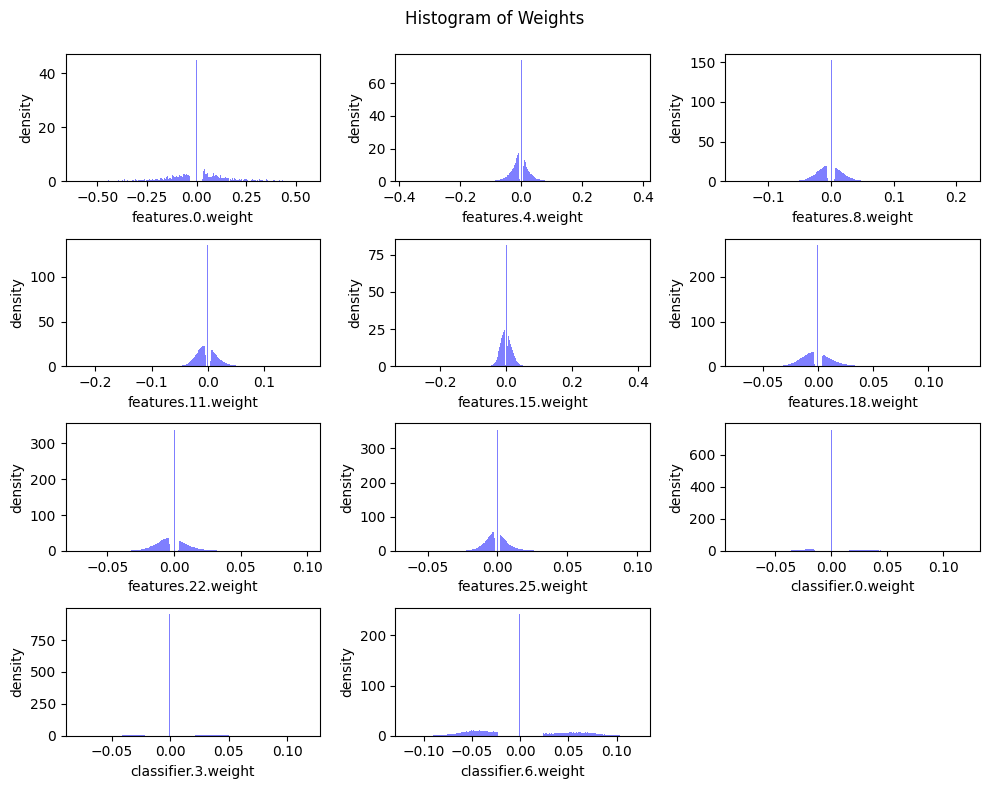

In [33]:
plot_weight_distribution(pruned_model)

In [34]:
print(f"Model size before pruning: {get_model_size(model, count_nonzero_only=True)/MiB:.2f} MiB")
print(f"Model size after pruning: {get_model_size(pruned_model, count_nonzero_only=True)/MiB:.2f} MiB")
print(f"Model Accuracy before pruning: {evaluate(model, dataloader['test']):.2f}%")
print(f"Model Accuracy after pruning: {evaluate(pruned_model, dataloader['test']):.2f}%")

Model size before pruning: 37.39 MiB
Model size after pruning: 28.05 MiB


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Model Accuracy before pruning: 70.77%


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Model Accuracy after pruning: 70.59%


In [35]:
torch.save(pruned_model, "unstructured_pruned_model.pth")


## Task 1.2: Structured Pruning

In [36]:
# Define transformations for train and test separately
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))  # CIFAR-100 normalization
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))  # CIFAR-100 normalization
    ]),
}

# Create datasets and dataloaders
dataset = {}
for split in ["train", "test"]:
    dataset[split] = datasets.CIFAR100(
        root="./data/cifar100",
        train=(split == "train"),
        download=True,
        transform=data_transforms[split],
    )

dataloader = {}
for split in ["train", "test"]:
    dataloader[split] = DataLoader(dataset[split], batch_size=512, shuffle=(split == "train"))

# Load pretrained VGG-11 model




Files already downloaded and verified
Files already downloaded and verified


In [37]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_vgg11_bn", pretrained=True)
model = model.cuda()  # Move model to GPU if available

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [38]:
def get_input_channel_importance(weight):
    in_channels = weight.shape[1]
    importances = []
    # compute the importance for each input channel
    for i_c in range(weight.shape[1]):
        channel_weight = weight.detach()[:, i_c]
        importance = torch.norm(channel_weight, p='fro')
        importances.append(importance.view(1))
    return torch.cat(importances)

@torch.no_grad()
def apply_channel_sorting(model):
    model = copy.deepcopy(model)
    all_convs = [m for m in model.features if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.features if isinstance(m, nn.BatchNorm2d)]

    # iterate through conv layers
    for i_conv in range(len(all_convs) - 1):
        prev_conv = all_convs[i_conv]
        prev_bn = all_bns[i_conv]
        next_conv = all_convs[i_conv + 1]

        # note that we always compute the importance according to input channels
        importance = get_input_channel_importance(next_conv.weight)
        # sorting from large to small
        sort_idx = torch.argsort(importance, descending=True)

        # apply to previous conv and its following bn
        prev_conv.weight.copy_(torch.index_select(
            prev_conv.weight.detach(), 0, sort_idx))
        for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
            tensor_to_apply = getattr(prev_bn, tensor_name)
            tensor_to_apply.copy_(
                torch.index_select(tensor_to_apply.detach(), 0, sort_idx)
            )

        # apply to the next conv input
        next_conv.weight.copy_(torch.index_select(
            next_conv.weight.detach(), 1, sort_idx))

    return model

def channel_prune(model, pruning_ratio):
    """
    Prune channels based on the pruning ratio
    """
    model = copy.deepcopy(model)
    num_channels = [m.weight.shape[0] for m in model.features if isinstance(m, nn.Conv2d)]

    for i, conv in enumerate([m for m in model.features if isinstance(m, nn.Conv2d)]):
        num_keep = int(num_channels[i] * (1 - pruning_ratio))
        # Create pruning mask
        mask = torch.zeros_like(conv.weight)
        mask[:num_keep] = 1
        # Apply mask
        conv.weight.data.mul_(mask)

    return model

# Test the implementation
channel_pruning_ratio = 0.25  # pruned-out ratio

print(" * Without sorting...")
pruned_model = channel_prune(model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

print(" * With sorting...")
sorted_model = apply_channel_sorting(model)
pruned_model = channel_prune(sorted_model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

 * Without sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=1.53%
 * With sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=5.35%


In [39]:
print(f"Model size before pruning: {get_model_size(model)/MiB:.2f} MiB")
print(f"Model size after pruning: {get_model_size(pruned_model, count_nonzero_only=True)/MiB:.2f} MiB")

Model size before pruning: 37.39 MiB
Model size after pruning: 28.60 MiB



Analyzing sensitivity of layer: features.0
Sparsity: 0.00, Accuracy: 70.77%, Drop: 0.00%
Sparsity: 0.25, Accuracy: 69.28%, Drop: 1.49%
Sparsity: 0.50, Accuracy: 59.60%, Drop: 11.17%
Sparsity: 0.75, Accuracy: 23.98%, Drop: 46.79%

Analyzing sensitivity of layer: features.4
Sparsity: 0.00, Accuracy: 70.77%, Drop: 0.00%
Sparsity: 0.25, Accuracy: 61.38%, Drop: 9.39%
Sparsity: 0.50, Accuracy: 24.57%, Drop: 46.20%
Sparsity: 0.75, Accuracy: 4.14%, Drop: 66.63%

Analyzing sensitivity of layer: features.8
Sparsity: 0.00, Accuracy: 70.77%, Drop: 0.00%
Sparsity: 0.25, Accuracy: 48.84%, Drop: 21.93%
Sparsity: 0.50, Accuracy: 4.09%, Drop: 66.68%
Sparsity: 0.75, Accuracy: 1.00%, Drop: 69.77%

Analyzing sensitivity of layer: features.11
Sparsity: 0.00, Accuracy: 70.77%, Drop: 0.00%
Sparsity: 0.25, Accuracy: 57.77%, Drop: 13.00%
Sparsity: 0.50, Accuracy: 18.42%, Drop: 52.35%
Sparsity: 0.75, Accuracy: 4.17%, Drop: 66.60%

Analyzing sensitivity of layer: features.15
Sparsity: 0.00, Accuracy: 70.77%, Dr

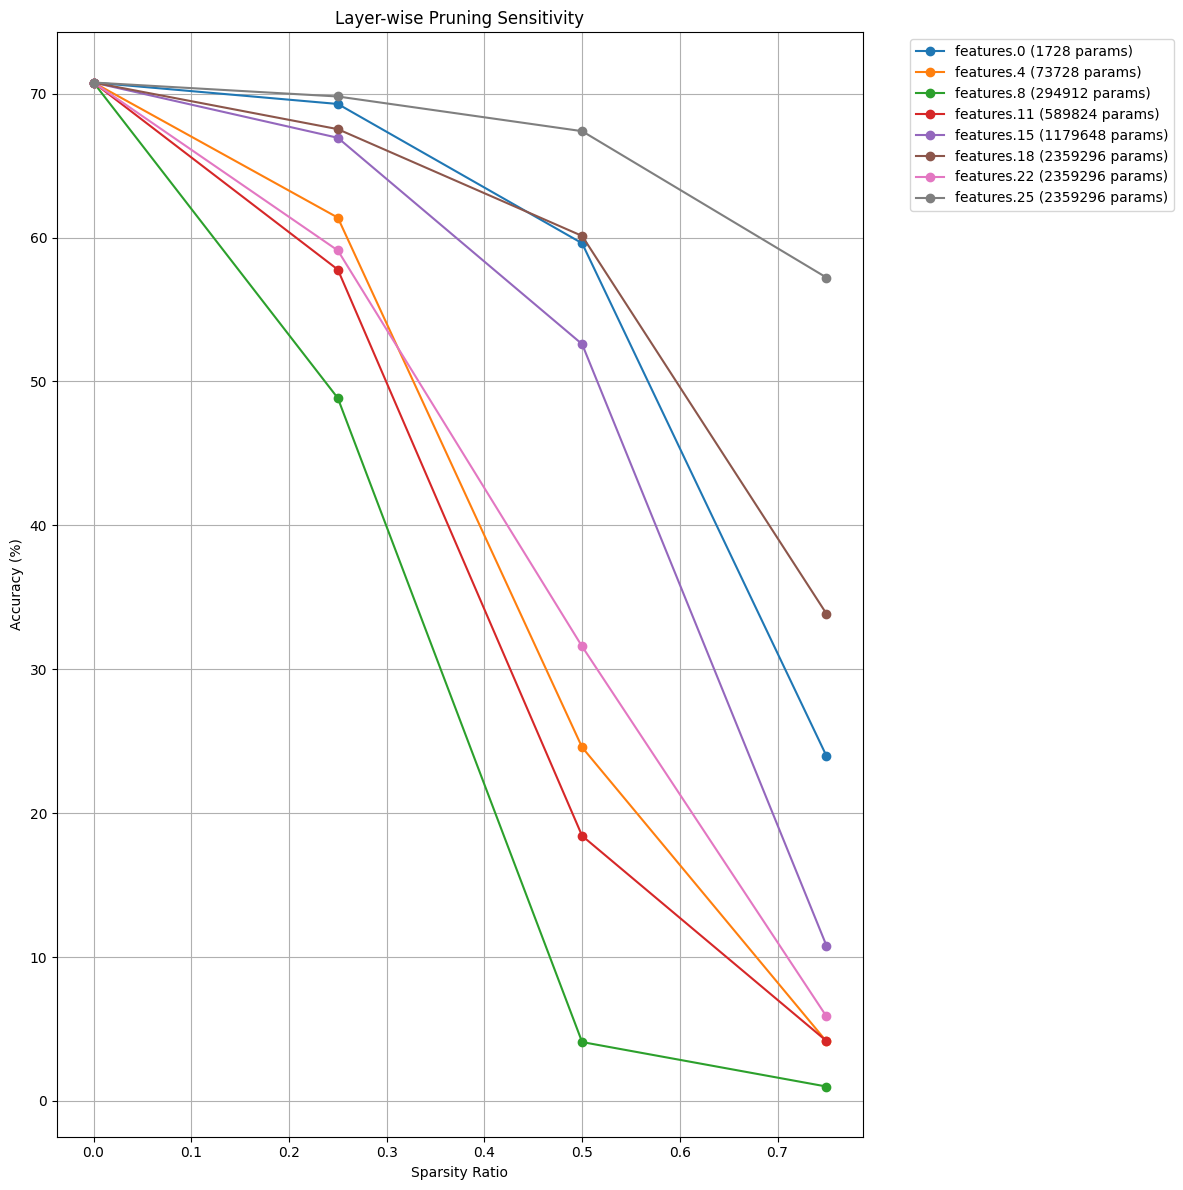

In [40]:
def analyze_layer_sensitivity_structured(
    model: nn.Module,
    dataloader: DataLoader,
    sparsity_levels: List[float],
    verbose: bool = True
) -> Dict:
    """
    Analyze sensitivity of each layer to structured pruning by independently pruning
    channels and measuring accuracy impact.
    """
    results = {}
    base_accuracy = evaluate(model, dataloader, verbose=False)

    # Get all convolutional layers

    for name, module in model.named_modules():
        if not isinstance(module, nn.Conv2d):
            continue

        conv = module
        layer_name = name
        layer_results = {
            'sparsities': [],
            'accuracies': [],
            'accuracy_drops': [],
            'param_count': conv.weight.numel(),
            'shape': list(conv.weight.shape),
            'channels': conv.out_channels
        }

        # Store original weights
        original_weights = conv.weight.data.clone()

        print(f"\nAnalyzing sensitivity of layer: {layer_name}")

        for sparsity in sparsity_levels:
            # Calculate number of channels to keep
            num_channels = conv.out_channels
            num_keep = int(num_channels * (1 - sparsity))

            # Create and apply channel mask
            mask = torch.zeros_like(conv.weight)
            mask[:num_keep] = 1
            conv.weight.data.mul_(mask)

            # Evaluate model
            accuracy = evaluate(model, dataloader, verbose=False)
            accuracy_drop = base_accuracy - accuracy

            # Store results
            layer_results['sparsities'].append(sparsity)
            layer_results['accuracies'].append(accuracy)
            layer_results['accuracy_drops'].append(accuracy_drop)

            if verbose:
                print(f"Sparsity: {sparsity:.2f}, Accuracy: {accuracy:.2f}%, "
                      f"Drop: {accuracy_drop:.2f}%")

            # Reset weights
            conv.weight.data = original_weights.clone()

        results[layer_name] = layer_results

    return results

def calculate_structured_sparsity_targets(
    sensitivity_results: Dict,
    target_overall_sparsity: float = 0.25
) -> Dict[str, float]:
    """
    Calculate per-layer channel pruning targets based on sensitivity analysis
    """
    total_channels = sum(layer['channels'] for layer in sensitivity_results.values())

    # Calculate sensitivity scores
    sensitivity_scores = {}
    for name, results in sensitivity_results.items():
        drops = np.array(results['accuracy_drops'])
        sparsities = np.array(results['sparsities'])
        sensitivity_scores[name] = np.mean(drops / (sparsities + 1e-6))

    # Inverse sensitivity scores
    max_score = max(sensitivity_scores.values())
    inverse_scores = {name: max_score - score
                     for name, score in sensitivity_scores.items()}

    # Normalize scores
    total_score = sum(inverse_scores.values())
    normalized_scores = {name: score / total_score
                        for name, score in inverse_scores.items()}

    # Calculate target sparsities
    layer_sparsities = {}
    for name, score in normalized_scores.items():
        channels = sensitivity_results[name]['channels']
        sparsity = target_overall_sparsity * (1 + score)
        sparsity = min(max(sparsity, 0.0), 0.75)  # Cap at 75% channel pruning
        layer_sparsities[name] = sparsity

    return layer_sparsities

def structured_layer_wise_prune(
    model: nn.Module,
    layer_sparsities: Dict[str, float]
) -> nn.Module:
    """
    Prunes channels in each layer based on specified sparsity levels.

    Args:
        model: The neural network model to prune.
        layer_sparsities: A dictionary where keys are layer names and values
                          are the sparsity levels (fractions) to apply.

    Returns:
        pruned_model: A copy of the original model with pruned channels.
    """
    # Create a deep copy of the model to avoid modifying the original
    pruned_model = copy.deepcopy(model)

    # Get all convolutional layers in the model's feature extractor
    conv_layers = [m for m in pruned_model.features if isinstance(m, nn.Conv2d)]

    # Apply pruning to each convolutional layer as per layer_sparsities
    for i, conv in enumerate(conv_layers):
        layer_name = f"conv_{i}"
        if layer_name in layer_sparsities:
            sparsity = layer_sparsities[layer_name]
            num_channels = conv.out_channels
            num_keep = int(num_channels * (1 - sparsity))

            # Calculate the importance of each channel (e.g., by L2 norm)
            channel_importance = conv.weight.data.view(num_channels, -1).norm(2, dim=1)

            # Sort channels by importance and select top `num_keep` channels
            _, sorted_indices = torch.sort(channel_importance, descending=True)
            keep_indices = sorted_indices[:num_keep]

            # Prune channels by retaining only `num_keep` most important channels
            conv.weight.data = conv.weight.data[keep_indices, :, :, :]
            if conv.bias is not None:
                conv.bias.data = conv.bias.data[keep_indices]

            # Update the output channels to reflect the reduced number
            conv.out_channels = num_keep

            print(f"Pruned {layer_name} to retain {num_keep} channels with sparsity level {sparsity:.2f}")

    return pruned_model

# Run the analysis
sparsity_levels = [0.0, 0.25, 0.5, 0.75]
sensitivity_results = analyze_layer_sensitivity_structured(sorted_model, dataloader['test'], sparsity_levels)

# Visualize results
plot_sensitivity_analysis(sensitivity_results)



In [41]:
# Calculate and apply targeted layer-wise sparsity
layer_sparsities = calculate_structured_sparsity_targets(sensitivity_results, 0.25)
print("\nRecommended layer-wise channel pruning targets for 25% overall sparsity:")
for layer, sparsity in layer_sparsities.items():
    print(f"{layer}: {sparsity:.3f}")


Recommended layer-wise channel pruning targets for 25% overall sparsity:
features.0: 0.297
features.4: 0.270
features.8: 0.250
features.11: 0.264
features.15: 0.288
features.18: 0.299
features.22: 0.272
features.25: 0.310


In [42]:
torch.save(pruned_model, "strctured_pruned_model.pth")

In [43]:
import torch.optim as optim

def fine_tune_model(
    model: nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    num_epochs: int = 10,
    learning_rate: float = 0.001,
) -> nn.Module:
    # Set model to training mode
    model.train()

    # Define optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    criterion = nn.CrossEntropyLoss()

    best_accuracy = 0

    for epoch in range(num_epochs):
        total_loss = 0
        num_correct = 0
        num_samples = 0

        for inputs, targets in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            inputs, targets = inputs.cuda(), targets.cuda()

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            _, predicted = outputs.max(1)
            num_correct += (predicted == targets).sum().item()
            num_samples += targets.size(0)

        # Step the scheduler
        scheduler.step()

        # Calculate train accuracy for the epoch
        train_accuracy = (num_correct / num_samples) * 100
        avg_loss = total_loss / len(train_dataloader)

        # Evaluate on test set
        test_accuracy = evaluate(model, test_dataloader)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Train Accuracy: {train_accuracy:.2f}% | Test Accuracy: {test_accuracy:.2f}%")

        # Update best accuracy
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model = copy.deepcopy(model)

    print(f"Best Test Accuracy after fine-tuning: {best_accuracy:.2f}%")
    return best_model


fine_tuned_model = fine_tune_model(
    pruned_model,
    dataloader['train'],
    dataloader['test'],
    num_epochs=20,
    learning_rate=0.001
)


Epoch 1/20:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20] | Loss: 0.9632 | Train Accuracy: 74.35% | Test Accuracy: 58.40%


Epoch 2/20:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/20] | Loss: 1.0264 | Train Accuracy: 72.13% | Test Accuracy: 59.46%


Epoch 3/20:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/20] | Loss: 0.8361 | Train Accuracy: 76.90% | Test Accuracy: 58.67%


Epoch 4/20:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/20] | Loss: 0.7236 | Train Accuracy: 79.60% | Test Accuracy: 60.54%


Epoch 5/20:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/20] | Loss: 0.6397 | Train Accuracy: 81.67% | Test Accuracy: 60.18%


Epoch 6/20:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/20] | Loss: 0.3094 | Train Accuracy: 90.72% | Test Accuracy: 66.29%


Epoch 7/20:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/20] | Loss: 0.1934 | Train Accuracy: 94.00% | Test Accuracy: 66.22%


Epoch 8/20:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/20] | Loss: 0.1493 | Train Accuracy: 95.24% | Test Accuracy: 66.34%


Epoch 9/20:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9/20] | Loss: 0.1261 | Train Accuracy: 96.05% | Test Accuracy: 66.52%


Epoch 10/20:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/20] | Loss: 0.1088 | Train Accuracy: 96.42% | Test Accuracy: 66.27%


Epoch 11/20:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [11/20] | Loss: 0.0849 | Train Accuracy: 97.33% | Test Accuracy: 66.70%


Epoch 12/20:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [12/20] | Loss: 0.0788 | Train Accuracy: 97.53% | Test Accuracy: 66.84%


Epoch 13/20:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [13/20] | Loss: 0.0772 | Train Accuracy: 97.53% | Test Accuracy: 66.86%


Epoch 14/20:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [14/20] | Loss: 0.0715 | Train Accuracy: 97.67% | Test Accuracy: 66.80%


Epoch 15/20:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [15/20] | Loss: 0.0718 | Train Accuracy: 97.72% | Test Accuracy: 66.79%


Epoch 16/20:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [16/20] | Loss: 0.0683 | Train Accuracy: 97.82% | Test Accuracy: 66.83%


Epoch 17/20:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [17/20] | Loss: 0.0697 | Train Accuracy: 97.74% | Test Accuracy: 66.79%


Epoch 18/20:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [18/20] | Loss: 0.0660 | Train Accuracy: 97.93% | Test Accuracy: 66.76%


Epoch 19/20:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [19/20] | Loss: 0.0684 | Train Accuracy: 97.79% | Test Accuracy: 66.79%


Epoch 20/20:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [20/20] | Loss: 0.0626 | Train Accuracy: 98.00% | Test Accuracy: 66.78%
Best Test Accuracy after fine-tuning: 66.86%


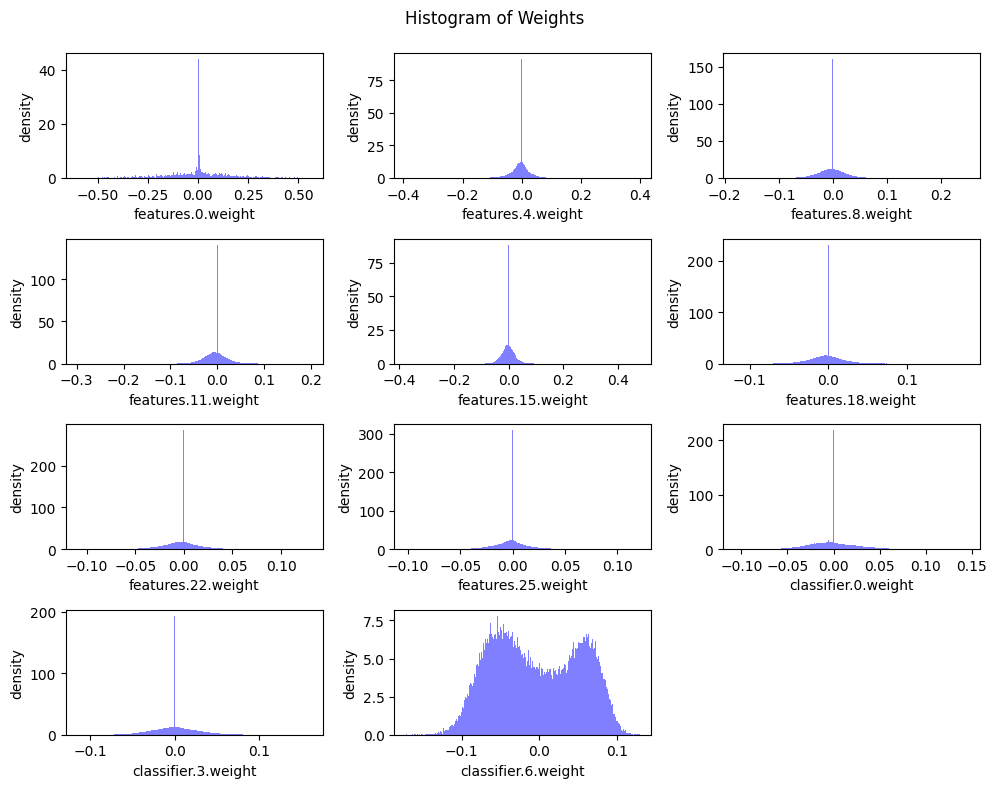

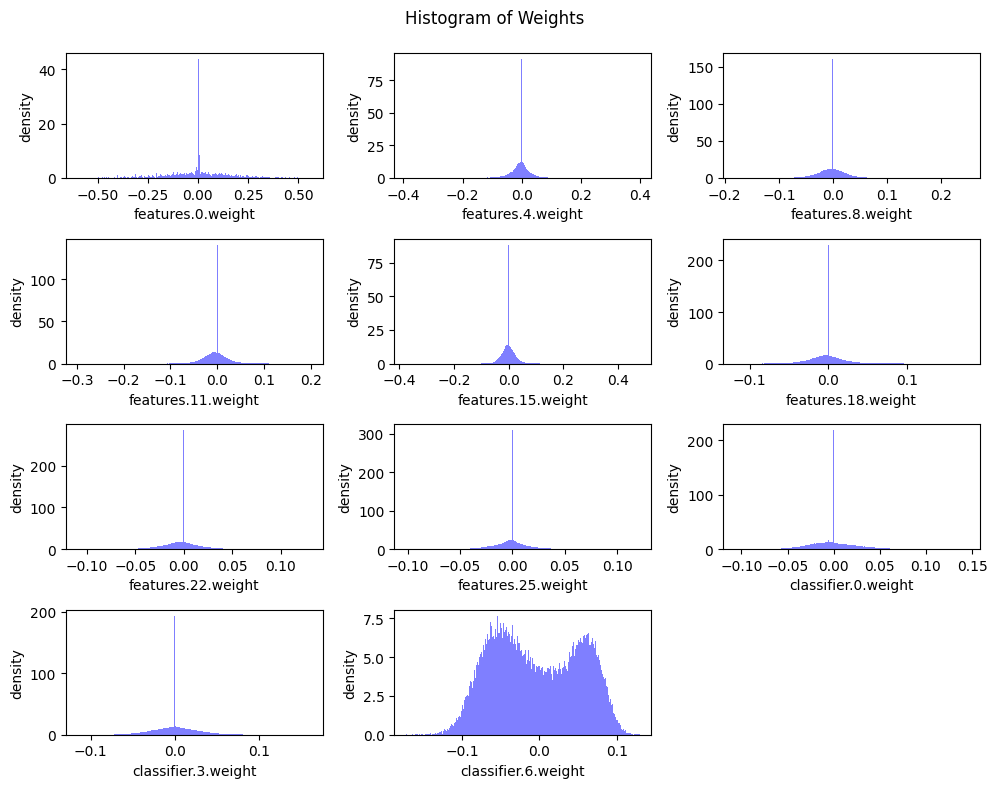

In [44]:
plot_weight_distribution(pruned_model)

plot_weight_distribution(fine_tuned_model)


In [45]:
print(f"Fine-tuned model size: {get_model_size(fine_tuned_model, count_nonzero_only=True)/MiB:.2f} MiB")
torch.save(fine_tuned_model, "ft_structured_pruned.pth")

Fine-tuned model size: 28.62 MiB


# Task 1.3: Model Comparison and GRAD-CAM Analysis

In [17]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39587 sha256=764071c16c2f8649a0724e8d96b9b880efd41117ea176fd46d7487d317edb86a
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [18]:
import torch
import numpy as np
import cv2
import time
from torchvision import transforms
from torchvision.datasets import CIFAR100
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
from PIL import Image
import copy


image_indices = [11, 12, 13, 14, 16, 25, 28]

In [46]:
print(model.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [47]:
original_model = model
unstructured_pruned_model = torch.load("unstructured_pruned_model.pth")
structured_pruned_model = torch.load("strctured_pruned_model.pth")

<ipython-input-47-0bc84f119054>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unstructured_pruned_model = torch.load("unstructured_pruned_model.pth")
<ipython-input-47-0b

In [48]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


# 1. GRAD-CAM Analysis
def gradcam_analysis(model, target_layer, image_indices, title):
    """Generate Grad-CAM visualizations for specified images."""
    model.eval()
    results = []

    for idx in image_indices:
        try:
            # Get image and label from dataset
            image, label = dataset['test'][idx]

            # Convert to numpy and normalize for display
            original_image = np.float32(image.permute(1, 2, 0).cpu().numpy())
            original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())
            rgb_image = np.uint8(255 * original_image)  # Convert to 8-bit for visualization

            # Prepare input tensor for model
            input_tensor = image.unsqueeze(0).cuda()

            # Initialize GradCAM
            cam = GradCAM(model=model, target_layers=[target_layer])

            # Generate Grad-CAM heatmap
            grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(label)])[0]

            # Normalize the Grad-CAM output
            if grayscale_cam.max() != grayscale_cam.min():
                grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min())

            # Convert grayscale_cam to RGB heatmap for side-by-side visualization
            cam_heatmap = np.uint8(255 * grayscale_cam)
            cam_heatmap = cv2.merge([cam_heatmap, cam_heatmap, cam_heatmap])

            # Create overlay image with heatmap
            cam_image = show_cam_on_image(original_image, grayscale_cam, use_rgb=True)

            # Concatenate images horizontally for comparison
            images = np.hstack((rgb_image, cam_heatmap, cam_image))

            # Display concatenated images
            plt.figure(figsize=(12, 4))
            plt.imshow(images)
            plt.axis('off')
            plt.title(f"{title} - Class: {label}")
            plt.show()

            # Append results to the list
            results.append({
                'original': rgb_image,
                'heatmap': cam_heatmap,
                'overlay': cam_image
            })

        except Exception as e:
            print(f"Error processing image {idx}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue

    return results

# 2. Inference Time Measurement
def measure_inference_time(model, input_tensor, num_runs=50):
    """Measure the inference time of a model."""
    model.eval()
    times = []
    with torch.no_grad():
        for _ in range(num_runs):
            start_time = time.time()
            _ = model(input_tensor)
            times.append(time.time() - start_time)

    # Calculate mean and standard deviation
    mean_time = sum(times) / len(times)
    std_time = np.std(times)

    return mean_time, std_time

# 3. Plot Accuracy vs. Target Sparsity
def plot_accuracy_vs_sparsity(model, dataloader, sparsity_levels):
    accuracies = []
    for sparsity in sparsity_levels:
        pruned_model = channel_prune(model, sparsity)
        pruned_model = fine_tune_model(pruned_model, dataloader['train'], dataloader['test'], num_epochs=5)
        accuracy = evaluate(pruned_model, dataloader['test'])
        accuracies.append(accuracy)
        print(f"Sparsity: {sparsity}, Accuracy: {accuracy:.2f}%")

    plt.figure(figsize=(8, 6))
    plt.plot(sparsity_levels, accuracies, marker='o')
    plt.xlabel("Target Sparsity")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy vs. Target Sparsity")
    plt.grid(True)
    plt.show()


def analyze_models(original_model, unstructured_pruned_model, structured_pruned_model,
                  image_indices, dataloader):
    # Ensure models are on GPU and in eval mode
    test_dataloader = dataloader['test']
    structured_pruned_model = fine_tune_model(structured_pruned_model,dataloader['train'],dataloader['test'])
    models = [original_model, unstructured_pruned_model, structured_pruned_model]
    model_names = ["Original", "Unstructured Pruned", "Structured Pruned"]

    for model in models:
        model.cuda()
        model.eval()

        # Enable gradients for the entire model
        for param in model.parameters():
            param.requires_grad = True

    # 1. Grad-CAM Analysis
    for model, name in zip(models, model_names):
        print(f"\nGrad-CAM Analysis for {name} Model")
        # Get the last convolutional layer
        target_layer = model.features[25]

        gradcam_analysis(model, target_layer, image_indices, name)

    # 2. Model Size and Inference Time
    input_tensor = next(iter(test_dataloader))[0][:1].cuda()

    print("\nModel Size Comparison:")
    for model, name in zip(models, model_names):
        size = get_model_size(model, count_nonzero_only=True) / MiB
        print(f"{name} Model Size: {size:.2f} MiB")

    print("\nInference Time Comparison:")
    for model, name in zip(models, model_names):
        mean_time, std_time = measure_inference_time(model, input_tensor)
        print(f"{name} Model: {mean_time*1000:.2f} ± {std_time*1000:.2f} ms")

    # 3. Accuracy vs Sparsity
    sparsity_levels = np.linspace(0, 0.5, 6)
    print("\nAnalyzing Accuracy vs Sparsity...")
    plot_accuracy_vs_sparsity(original_model, dataloader, sparsity_levels)

Epoch 1/10:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/10] | Loss: 0.9596 | Train Accuracy: 74.86% | Test Accuracy: 58.14%


Epoch 2/10:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/10] | Loss: 1.0326 | Train Accuracy: 71.82% | Test Accuracy: 58.90%


Epoch 3/10:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/10] | Loss: 0.7874 | Train Accuracy: 78.01% | Test Accuracy: 60.86%


Epoch 4/10:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/10] | Loss: 0.6919 | Train Accuracy: 80.56% | Test Accuracy: 60.25%


Epoch 5/10:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/10] | Loss: 0.6491 | Train Accuracy: 81.52% | Test Accuracy: 59.74%


Epoch 6/10:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/10] | Loss: 0.3161 | Train Accuracy: 90.50% | Test Accuracy: 65.89%


Epoch 7/10:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/10] | Loss: 0.2002 | Train Accuracy: 93.84% | Test Accuracy: 66.09%


Epoch 8/10:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/10] | Loss: 0.1565 | Train Accuracy: 95.02% | Test Accuracy: 66.36%


Epoch 9/10:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9/10] | Loss: 0.1281 | Train Accuracy: 95.91% | Test Accuracy: 66.52%


Epoch 10/10:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/10] | Loss: 0.1059 | Train Accuracy: 96.61% | Test Accuracy: 66.00%
Best Test Accuracy after fine-tuning: 66.52%

Grad-CAM Analysis for Original Model


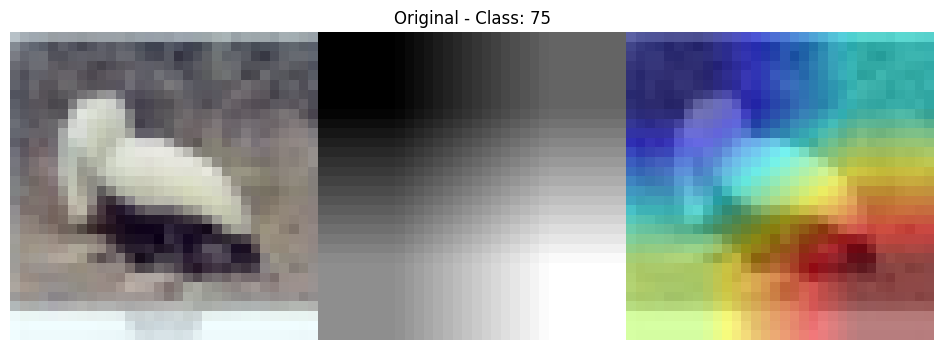

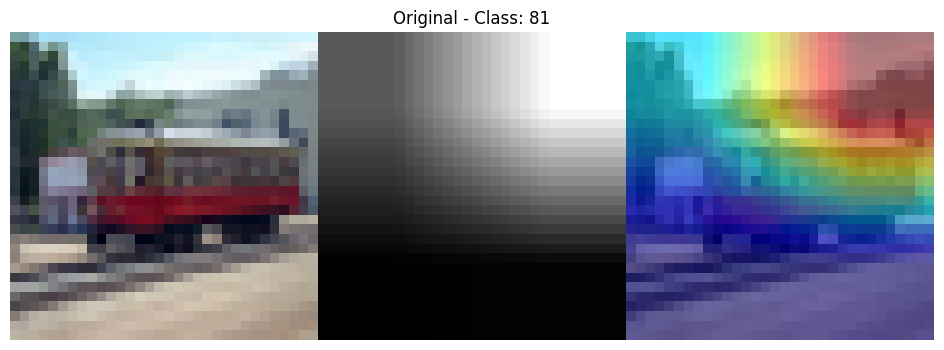

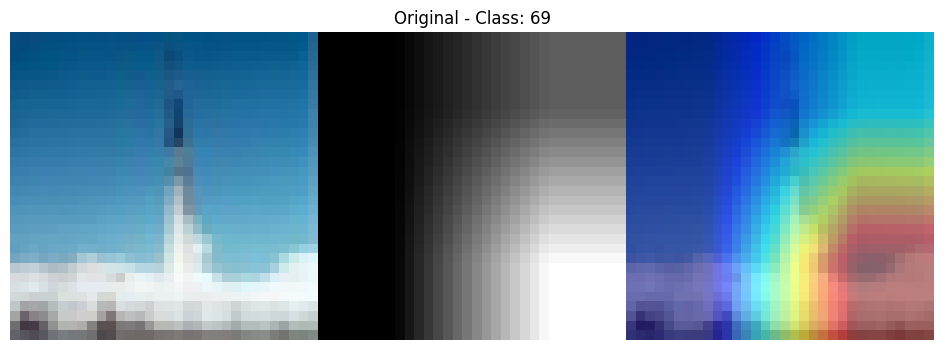

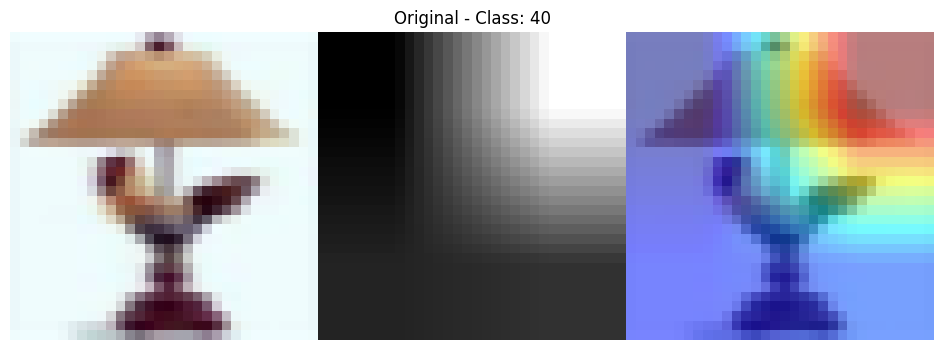

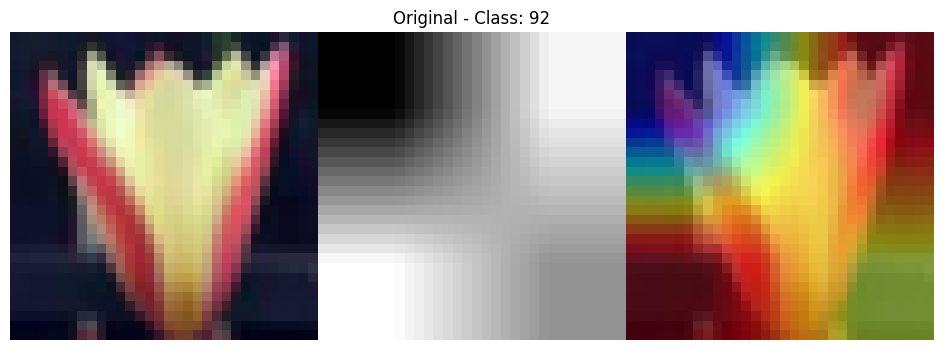

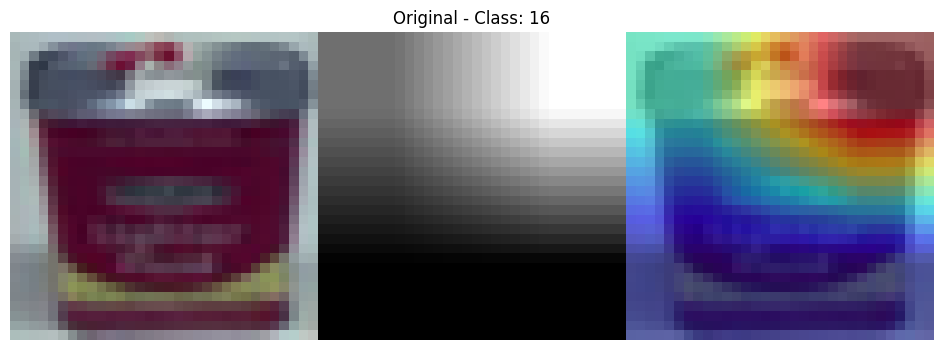

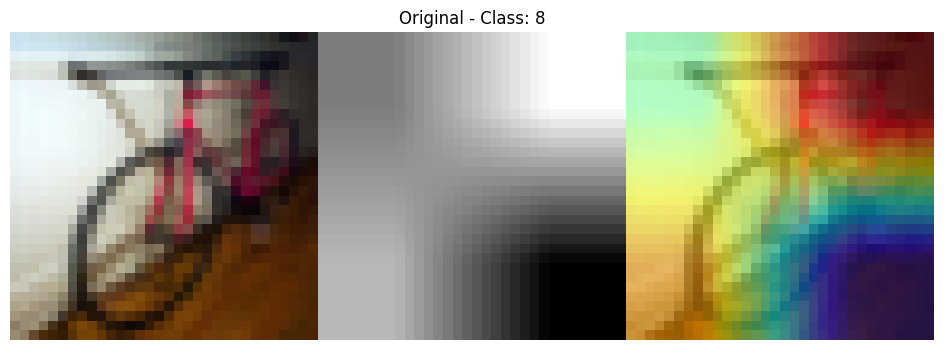


Grad-CAM Analysis for Unstructured Pruned Model


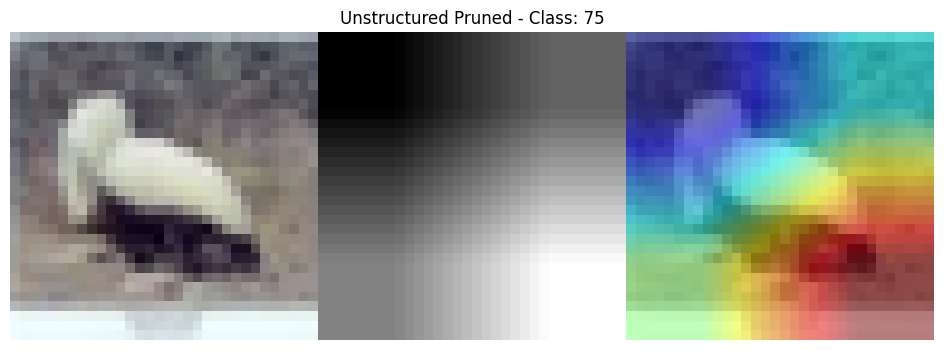

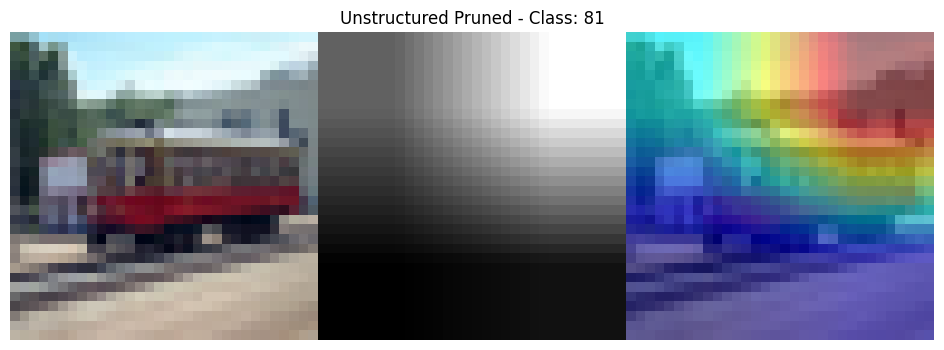

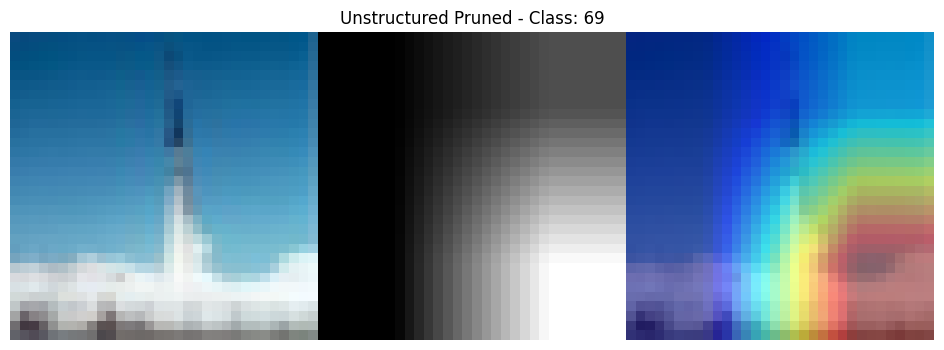

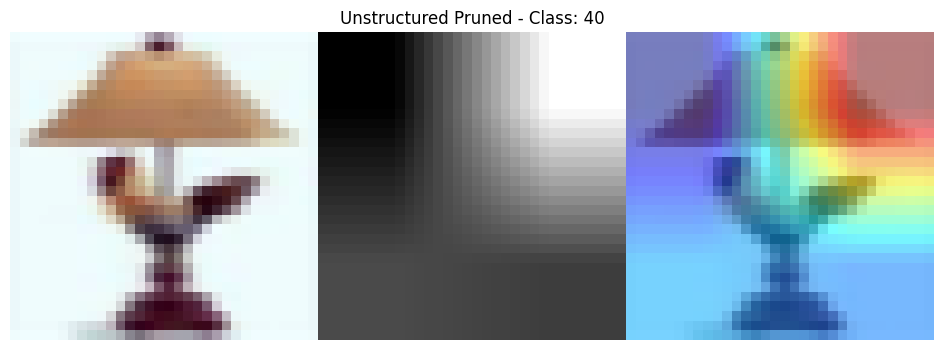

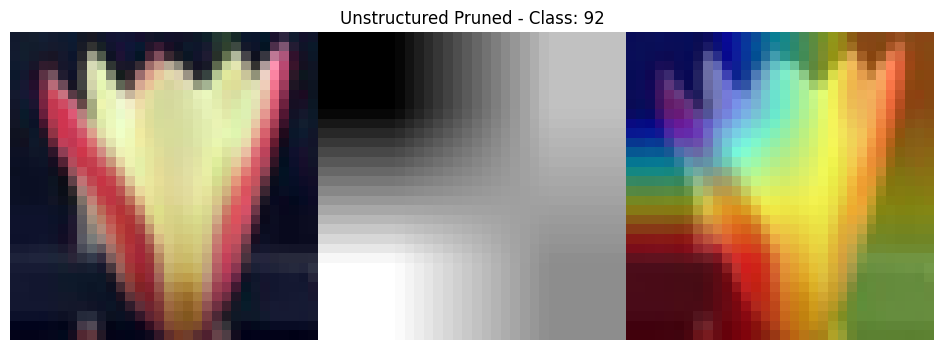

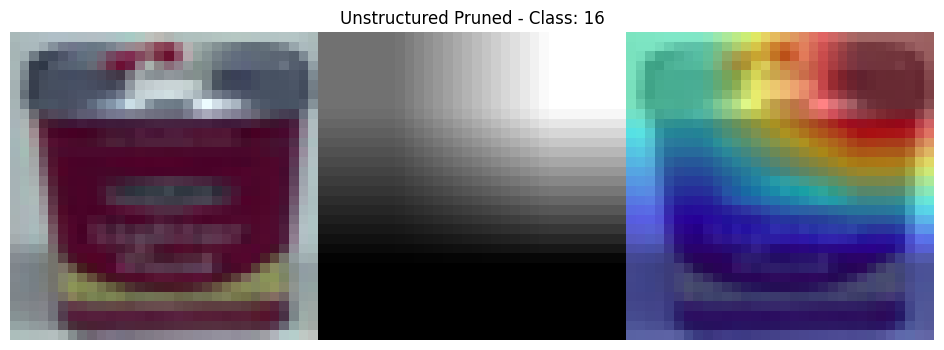

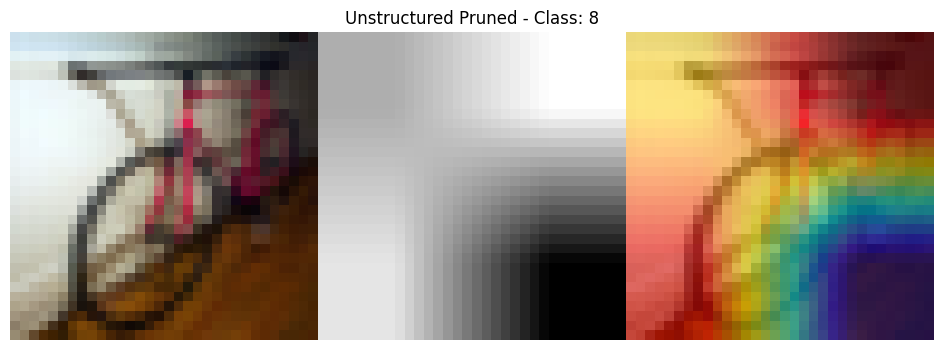


Grad-CAM Analysis for Structured Pruned Model


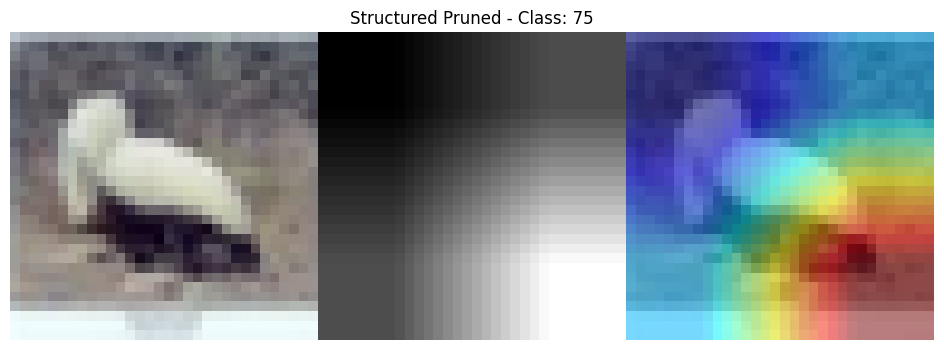

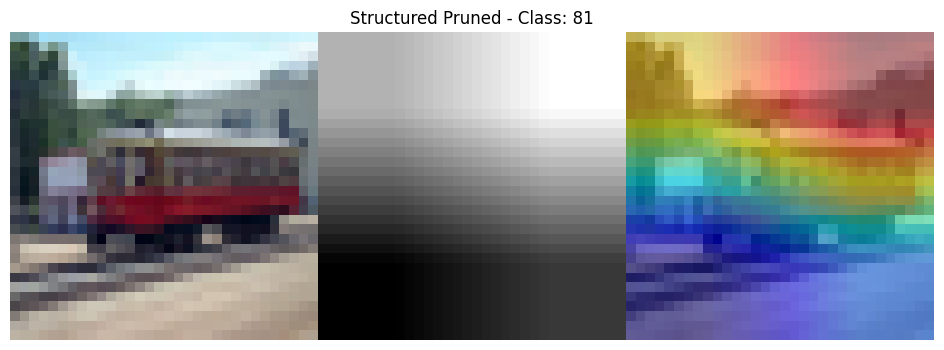

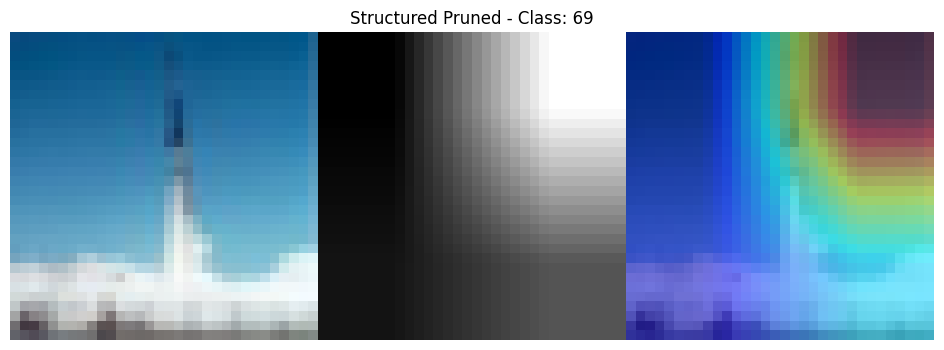

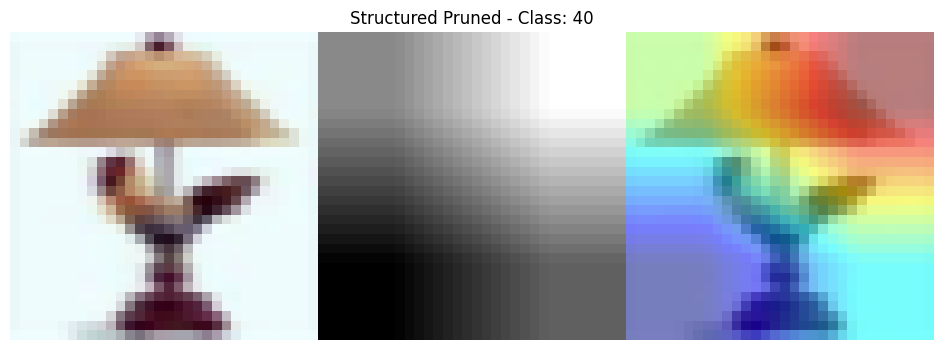

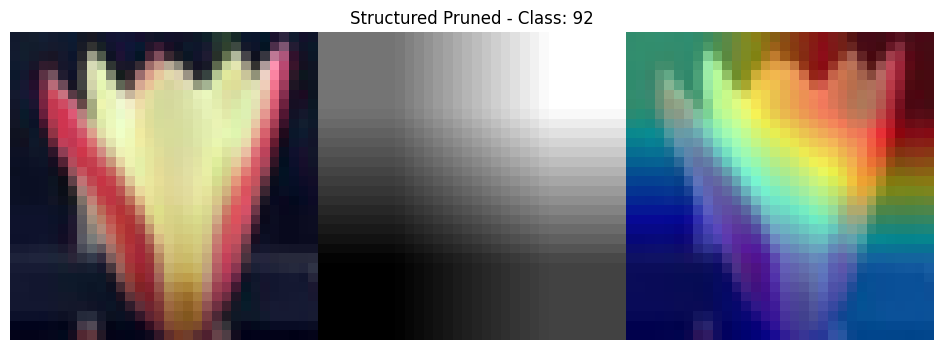

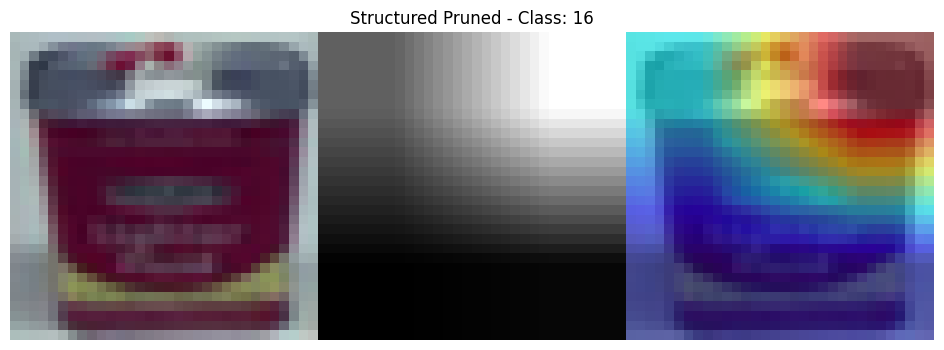

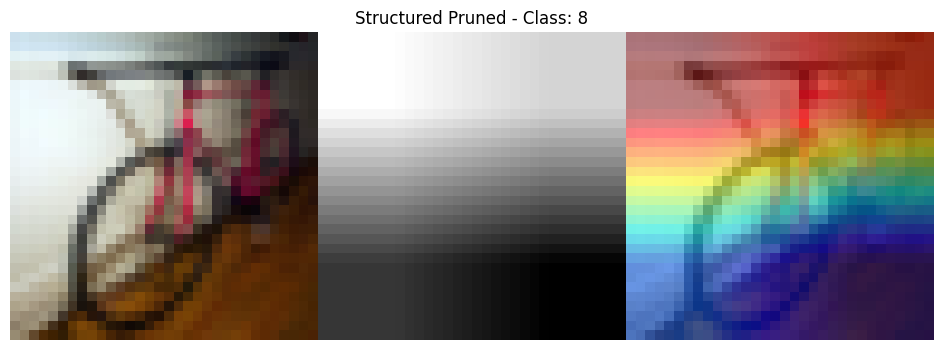


Model Size Comparison:
Original Model Size: 37.39 MiB
Unstructured Pruned Model Size: 28.05 MiB
Structured Pruned Model Size: 28.62 MiB

Inference Time Comparison:
Original Model: 1.24 ± 0.22 ms
Unstructured Pruned Model: 1.80 ± 0.30 ms
Structured Pruned Model: 1.43 ± 0.30 ms

Analyzing Accuracy vs Sparsity...


Epoch 1/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/5] | Loss: 0.6497 | Train Accuracy: 82.79% | Test Accuracy: 60.83%


Epoch 2/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/5] | Loss: 1.0450 | Train Accuracy: 72.13% | Test Accuracy: 61.85%


Epoch 3/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/5] | Loss: 0.6767 | Train Accuracy: 80.89% | Test Accuracy: 62.05%


Epoch 4/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/5] | Loss: 0.5771 | Train Accuracy: 83.46% | Test Accuracy: 62.39%


Epoch 5/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/5] | Loss: 0.5159 | Train Accuracy: 85.12% | Test Accuracy: 61.83%
Best Test Accuracy after fine-tuning: 62.39%


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparsity: 0.0, Accuracy: 62.39%


Epoch 1/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/5] | Loss: 0.8155 | Train Accuracy: 78.55% | Test Accuracy: 59.70%


Epoch 2/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/5] | Loss: 1.0303 | Train Accuracy: 72.48% | Test Accuracy: 60.57%


Epoch 3/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/5] | Loss: 0.7135 | Train Accuracy: 80.29% | Test Accuracy: 59.45%


Epoch 4/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/5] | Loss: 0.6465 | Train Accuracy: 81.50% | Test Accuracy: 60.22%


Epoch 5/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/5] | Loss: 0.5983 | Train Accuracy: 83.10% | Test Accuracy: 61.09%
Best Test Accuracy after fine-tuning: 61.09%


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparsity: 0.1, Accuracy: 61.09%


Epoch 1/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/5] | Loss: 1.0670 | Train Accuracy: 72.25% | Test Accuracy: 57.33%


Epoch 2/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/5] | Loss: 1.3112 | Train Accuracy: 65.91% | Test Accuracy: 58.95%


Epoch 3/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/5] | Loss: 0.8533 | Train Accuracy: 76.11% | Test Accuracy: 60.54%


Epoch 4/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/5] | Loss: 0.7435 | Train Accuracy: 79.12% | Test Accuracy: 61.05%


Epoch 5/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/5] | Loss: 0.7001 | Train Accuracy: 80.06% | Test Accuracy: 60.93%
Best Test Accuracy after fine-tuning: 61.05%


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparsity: 0.2, Accuracy: 61.05%


Epoch 1/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/5] | Loss: 1.3477 | Train Accuracy: 65.64% | Test Accuracy: 57.86%


Epoch 2/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/5] | Loss: 1.4218 | Train Accuracy: 62.76% | Test Accuracy: 58.91%


Epoch 3/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/5] | Loss: 0.9901 | Train Accuracy: 72.57% | Test Accuracy: 60.33%


Epoch 4/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/5] | Loss: 0.8798 | Train Accuracy: 75.28% | Test Accuracy: 58.41%


Epoch 5/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/5] | Loss: 0.8287 | Train Accuracy: 76.74% | Test Accuracy: 60.22%
Best Test Accuracy after fine-tuning: 60.33%


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparsity: 0.30000000000000004, Accuracy: 60.33%


Epoch 1/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/5] | Loss: 1.7003 | Train Accuracy: 57.17% | Test Accuracy: 55.28%


Epoch 2/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/5] | Loss: 1.5694 | Train Accuracy: 59.04% | Test Accuracy: 56.90%


Epoch 3/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/5] | Loss: 1.1822 | Train Accuracy: 67.87% | Test Accuracy: 59.59%


Epoch 4/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/5] | Loss: 1.0663 | Train Accuracy: 70.34% | Test Accuracy: 58.72%


Epoch 5/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/5] | Loss: 0.9898 | Train Accuracy: 72.42% | Test Accuracy: 59.60%
Best Test Accuracy after fine-tuning: 59.60%


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparsity: 0.4, Accuracy: 59.60%


Epoch 1/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/5] | Loss: 2.2901 | Train Accuracy: 43.31% | Test Accuracy: 48.88%


Epoch 2/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/5] | Loss: 2.0875 | Train Accuracy: 46.44% | Test Accuracy: 52.49%


Epoch 3/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/5] | Loss: 1.4983 | Train Accuracy: 59.37% | Test Accuracy: 54.38%


Epoch 4/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/5] | Loss: 1.3646 | Train Accuracy: 62.62% | Test Accuracy: 55.71%


Epoch 5/5:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/5] | Loss: 1.2734 | Train Accuracy: 64.88% | Test Accuracy: 57.18%
Best Test Accuracy after fine-tuning: 57.18%


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparsity: 0.5, Accuracy: 57.18%


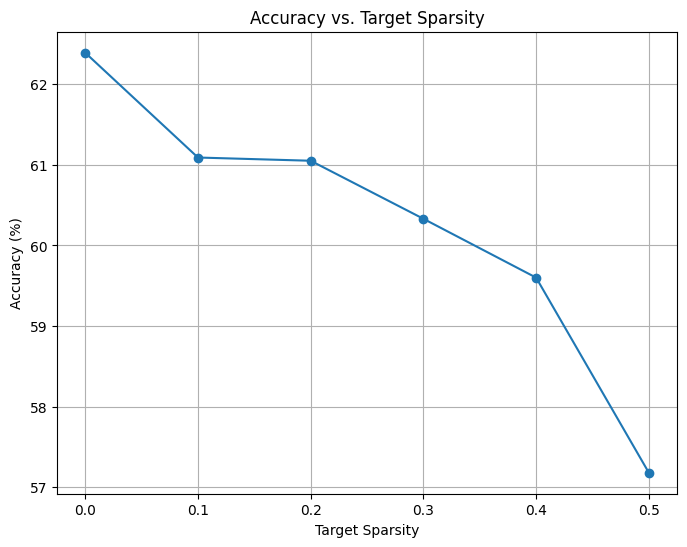

In [49]:
analyze_models(original_model, unstructured_pruned_model, structured_pruned_model, image_indices, dataloader)